<h1 style='color:orange; font-weight:bold; text-align:center'>Dependency Parsing</h1>

In [25]:
!pip install -q stanza deplacy graphviz spark-nlp spark-nlp-display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.9 MB/s eta 0:00:00


In [35]:
import stanza                                              # for NLP tasks
import deplacy                                             # for visualizing depdenency tree
import graphviz                                            # for visualizing dependency tree
import pandas as pd                                        # for data wrangling
from IPython.display import Image, display
import spacy
from spacy import displacy

import sparknlp
from sparknlp.annotator import Tokenizer, PerceptronModel
from sparknlp.base import DocumentAssembler
from sparknlp_display import DependencyParserVisualizer
from pyspark.ml import Pipeline
import pyspark.sql.functions as F

In [ ]:
# download lang models
stanza.download('id', verbose=False)
stanza.download('en', verbose=False)

## **1 Indonesian**

In [ ]:
# create pipeline for id texts
nlp = stanza.Pipeline('id')

# process sentence
doc = nlp("""Ini adalah kalimat biasa saja.""")

| Token	| Head	| Dep Relation	| Explanation |
| --- | --- | --- | --- |
| Ini	| adalah	| `nsubj`	| Subject of the copula "adalah" |
| adalah	| ROOT	| `cop`	| Main verb (copula) |
| kalimat	| adalah | `root`	| Predicative complement (noun) |
| biasa	| kalimat	| `amod`	| Adjective modifier of "kalimat" |
| saja	| biasa	| `advmod`	| Limiting adverb ("just") |
| .	| adalah	| `punct` | 	Sentence-ending punctuation |

**Comment**:
- "Ini" *this* (DET) is the subject of the sentence and is linked to the predicate by "adalah".
- "adalah" functions as a linking verb (V), connecting the subject to the predicate. For this reason, "adalah" in the sentence serves an equational copula. 
    - By the term *copula*, I mean a verb that links the subject of a sentence with its complement similar to "is", "am", and "are" in English. In Indonesian, the verb "adalah" can take at least three forms such as equational copula ("Ini adalah kucing."), attributive copula ("Bulu kucing ini lembut."), and existential copula ("Ada kucing di dalam keranjang.")
    - However, unlike English, the copula in Indonesian is not always obligatory (zero copula). Hence, we can alternatively say "Ini kalimat biasa saja" without "adalah" and still have a grammatical sentence.
- "kalimat" (sentence) is the core predicate or main word of the sentence.
- "biasa" (normal) modifies "kalimat" as an adjective.
- "saja" (just) modifies "biasa" or the predicate, giving it an adverbial nuance.
- The period ends the sentence and attaches to the root.

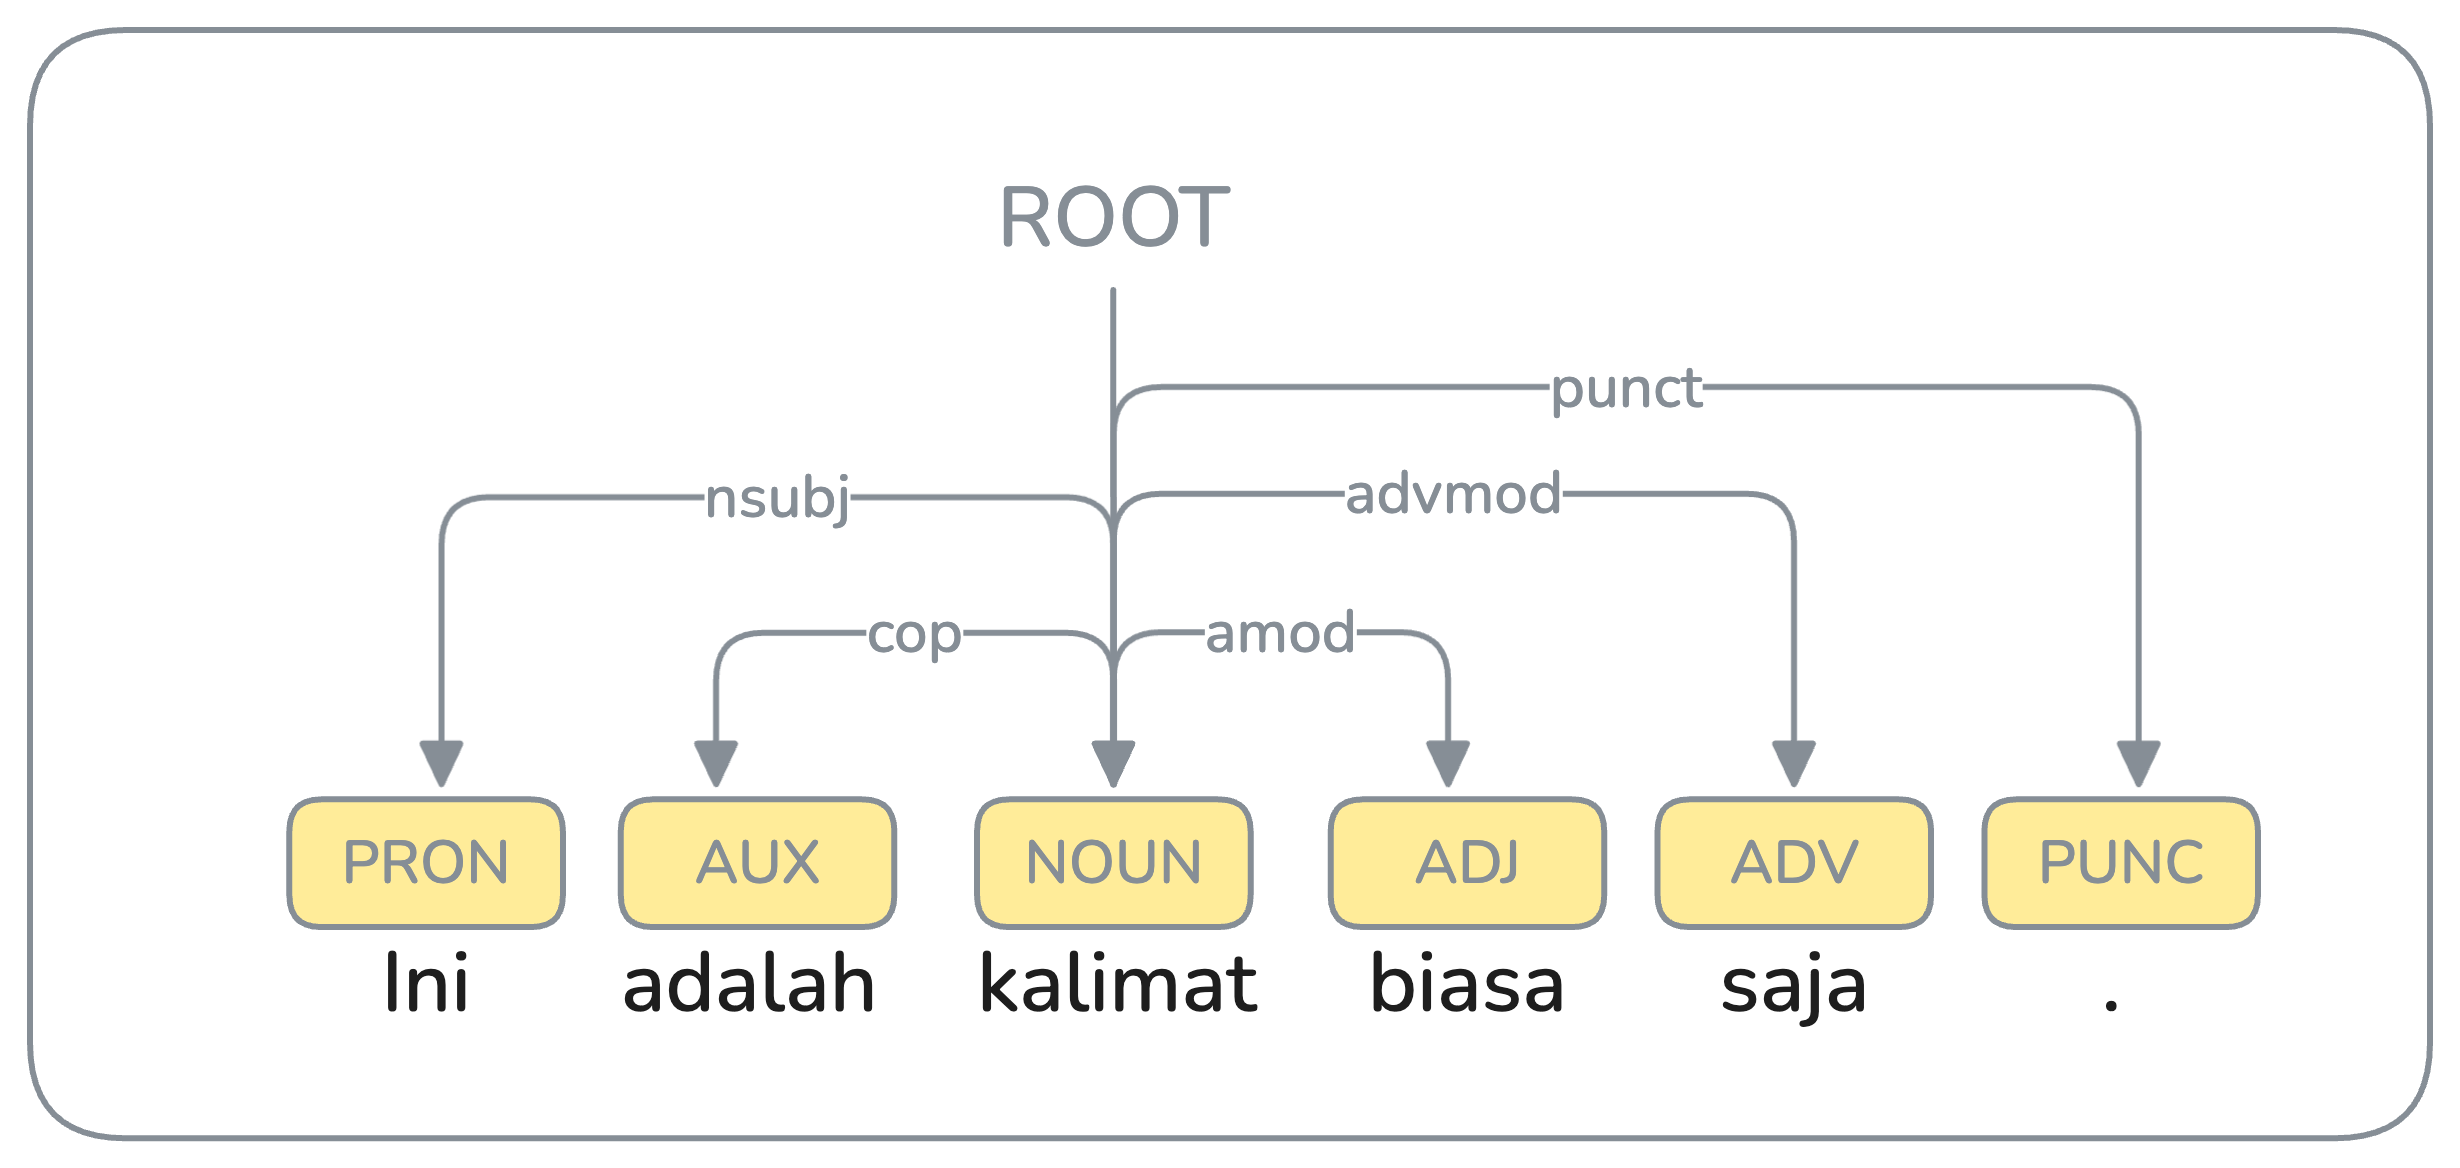

In [ ]:
# call speech analysis with Praat
display(Image("../img/sent-id.png", width=500))

**Comment**:
- The image above represents the dependency parsing made manually for sentence "Ini adalah kalimat biasa saja.", but as I said previously, the copula "adalah" is optional in Indonesian so we can drop the copula and get the dependency parsing below.
- If represented in a tree structure, the dependency parsing would look like this:
```bash
Ini     PRON   <══════╗         nsubj
kalimat NOUN   ═╗═╗═══╝═╗       root
biasa   ADJ    <╝ ║     ║       amod
saja    ADV    <══╝     ║       advmod
.       PUNCT  <════════╝       punct
```
- To note, in this notebook, I will demonstate how to implement the dependency parsing with the copula "adalah" only using the Stanza library.

In [ ]:
# print processed sentence
print(doc)

[
  [
    {
      "id": 1,
      "text": "Ini",
      "lemma": "ini",
      "upos": "PRON",
      "xpos": "B--",
      "feats": "PronType=Dem",
      "head": 3,
      "deprel": "nsubj",
      "start_char": 0,
      "end_char": 3
    },
    {
      "id": 2,
      "text": "adalah",
      "lemma": "adalah",
      "upos": "AUX",
      "xpos": "O--",
      "head": 3,
      "deprel": "cop",
      "start_char": 4,
      "end_char": 10
    },
    {
      "id": 3,
      "text": "kalimat",
      "lemma": "kalimat",
      "upos": "NOUN",
      "xpos": "NSD",
      "feats": "Number=Sing",
      "head": 0,
      "deprel": "root",
      "start_char": 11,
      "end_char": 18
    },
    {
      "id": 4,
      "text": "biasa",
      "lemma": "biasa",
      "upos": "ADJ",
      "xpos": "ASP",
      "head": 3,
      "deprel": "amod",
      "start_char": 19,
      "end_char": 24
    },
    {
      "id": 5,
      "text": "saja",
      "lemma": "saja",
      "upos": "ADV",
      "xpos": "D--",
      "head"

In [ ]:
rows = []
for sent in doc.sentences:
    for word in sent.words:
        rows.append({
            "id": word.id,
            "word": word.text,
            "head_id": word.head,
            "head": sent.words[word.head - 1].text if word.head > 0 else "root",
            "deprel": word.deprel
        })

df = pd.DataFrame(rows)
display(df)

,id,word,head_id,head,deprel
0,1,Ini,3,kalimat,nsubj
1,2,adalah,3,kalimat,cop
2,3,kalimat,0,root,root
3,4,biasa,3,kalimat,amod
4,5,saja,3,kalimat,advmod
5,6,.,3,kalimat,punct


In [ ]:
# visualize dependency tree: plain text
deplacy.render(doc)

Ini     PRON  <══════╗   nsubj
adalah  AUX   <════╗ ║   cop
kalimat NOUN  ═╗═╗═╝═╝═╗ root
biasa   ADJ   <╝ ║     ║ amod
saja    ADV   <══╝     ║ advmod
.       PUNCT <════════╝ punct


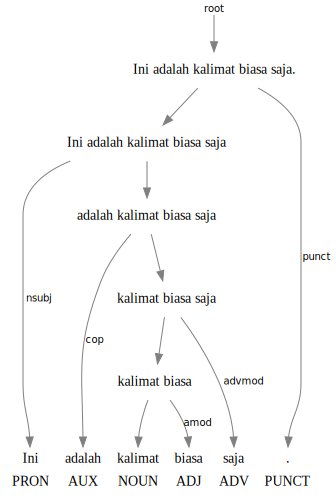

In [ ]:
# visualize dependency tree: graph
graphviz.Source(deplacy.dot(doc))

In [ ]:
# show dependency tree: interactive
deplacy.serve(doc, port=None)

In [ ]:
for sentence in doc.sentences:
    for word in sentence.words:
        print(f"Text: {word.text}, Lemma: {word.lemma}, POS: {word.upos}, Morph: {word.feats}")

Text: Ini, Lemma: ini, POS: PRON, Morph: PronType=Dem
Text: adalah, Lemma: adalah, POS: AUX, Morph: None
Text: kalimat, Lemma: kalimat, POS: NOUN, Morph: Number=Sing
Text: biasa, Lemma: biasa, POS: ADJ, Morph: None
Text: saja, Lemma: saja, POS: ADV, Morph: None
Text: ., Lemma: ., POS: PUNCT, Morph: None


## **2 English**

### **2.1 Stanza**

In [ ]:
en_nlp = stanza.Pipeline('en', preprocessors='tokenize,mwt,pos,lemma,depparse')

In [ ]:
sentence = 'This is a sentence.'
doc_en = nlp(sentence)

In [ ]:
en_rows = []
for sent in doc_en.sentences:
    for word in sent.words:
        en_rows.append({
            "id": word.id,
            "word": word.text,
            "head_id": word.head,
            "head": sent.words[word.head - 1].text if word.head > 0 else "root",
            "deprel": word.deprel
        })

en_df = pd.DataFrame(en_rows)
display(en_df)

,id,word,head_id,head,deprel
0,1,This,0,root,root
1,2,is,1,This,flat:name
2,3,a,2,is,flat:name
3,4,sentence,3,a,flat:name
4,5,.,1,This,punct


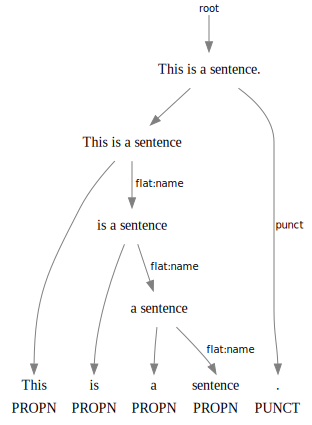

In [ ]:
# visualize dependency tree: graph
graphviz.Source(deplacy.dot(doc_en))

### **2.2 spaCy**

In [ ]:
en_model = spacy.load('en_core_web_sm')

In [ ]:
sent01 = en_model(u'This is a sentence.')
displacy.render(sent01, style='dep', jupyter=True, options={'distance':100})

In [ ]:
for word in sent01:
    print(f'{word.text:{12}} {word.pos_:{10}} {word.tag_:{8}} {spacy.explain(word.tag_)}')

This         PRON       DT       determiner
is           AUX        VBZ      verb, 3rd person singular present
a            DET        DT       determiner
sentence     NOUN       NN       noun, singular or mass
.            PUNCT      .        punctuation mark, sentence closer


### **2.3 Spark-NLP**

In [27]:
spark = sparknlp.start()

In [30]:
doc_assembler = DocumentAssembler().setInputCol('text').setOutputCol('document')
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('token')
pos_tagger = PerceptronModel.pretrained().setInputCols(['document', 'token']).setOutputCol('pos')
pipeline = Pipeline().setStages([doc_assembler, tokenizer, pos_tagger])

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


In [33]:
df = spark.createDataFrame([['This is a sentence.']]).toDF('text')
model = pipeline.fit(df)
result = model.transform(df)

In [34]:
# display results to check labels
result.select(
    F.explode(
        F.arrays_zip(
            result.token.result, result.token.begin,
            result.token.end, result.pos.result
        )
    ).alias("cols")
).select(
    F.expr("cols['0']").alias("token"),
    F.expr("cols['1']").alias("begin"),
    F.expr("cols['2']").alias("end"),
    F.expr("cols['3']").alias("pos"),
).show()

+--------+-----+---+---+
|   token|begin|end|pos|
+--------+-----+---+---+
|    This|    0|  3| DT|
|      is|    5|  6|VBZ|
|       a|    8|  8| DT|
|sentence|   10| 17| NN|
|       .|   18| 18|  .|
+--------+-----+---+---+

